## Figure 1:  Co-expressed genes share biological function and regulatory architecture

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import upsetplot as up
import ast
from tqdm.auto import tqdm 
tqdm.pandas()

# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *
from annotate_null_clusters import * 

# set higher figure resolution
import matplotlib as mpl
#mpl.rcParams['figure.dpi']= 1000

#### b) number of clusters across tissues

In [42]:
# load in the clusters data
clusters = load_across_tissues(config, load_cluster)

# make a palette
tissue_ids = load_tissue_ids(config)
tissue_pal = sns.color_palette('blend:#B83A4B,#FEC51D,#67AFD2', n_colors=len(tissue_ids))

# get total number of clusters and genes in clusters
cluster_counts = clusters.groupby('tissue_id').agg({'N_genes':sum, 'Transcripts':'nunique'})

/local/scratch/klawren/slrmtmp.47323354/ipykernel_9504/3554760375.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)
/local/scratch/klawren/slrmtmp.47323354/ipykernel_9504/3554760375.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


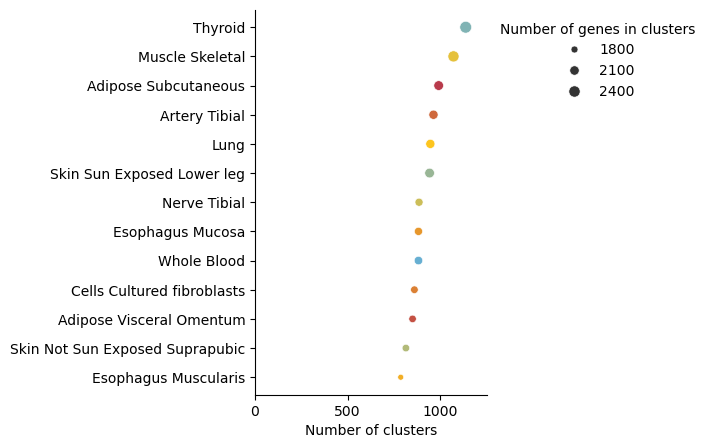

In [66]:
# plot showing number of clusters in each tissue
fig, ax = plt.subplots(figsize=(3,5))
ax = sns.scatterplot(cluster_counts.sort_values('Transcripts', ascending=False),hue_order=tissue_ids, x='Transcripts', hue='tissue_id', y='tissue_id', palette=tissue_pal, ax=ax, size='N_genes')
ax.set_xlim((0, ax.get_xlim()[1]+100))
ax.set_xlabel('Number of clusters')
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Keep only sample_size legend entries
handles, labels = ax.get_legend_handles_labels()
new_handles = []
new_labels = []
for handle, label in zip(handles, labels):
    if label.isnumeric():  # Assuming sample_size will be numeric and thus its labels will be numerical
        new_handles.append(handle)
        new_labels.append(label)
ax.legend(new_handles[::2], new_labels[::2], title='Number of genes in clusters', frameon=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

plt.tight_layout() 
plt.show()


#### c) histogram of size distribution of clusters


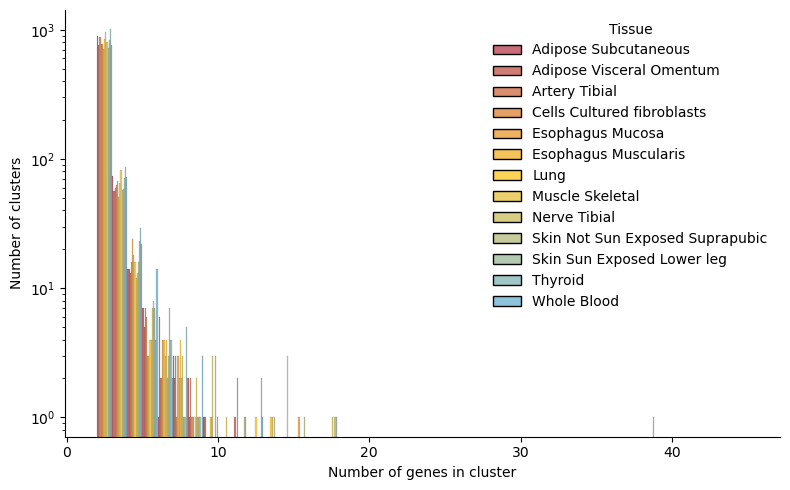

In [68]:
fig, ax = plt.subplots(figsize=(8,5))

sns.histplot(clusters, x='N_genes', color=tissue_pal[-1], ax=ax, hue='tissue_id', multiple='dodge', 
             hue_order=tissue_ids, palette=tissue_pal, bins=np.arange(2, clusters['N_genes'].max()), legend=True)
ax.set_ylabel('Number of clusters')
ax.set_xlabel('Number of genes in cluster')
ax.set_yscale('log')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customize the legend
legend = ax.get_legend()
new_labels = [label.get_text().replace('_', ' ') for label in legend.texts]
for t, new_label in zip(legend.texts, new_labels):
    t.set_text(new_label)
legend.get_frame().set_visible(False)
legend.set_title("Tissue")

# Show plot
plt.tight_layout() 
plt.show()


#### d) Forest plot, split by positive and negative with fraction of clusters in each category

In [72]:
# get just the ones with matched enahncer
enhancer_tissue_ids = ['Artery_Tibial', 'Cells_Cultured_fibroblasts', 'Lung', 'Muscle_Skeletal', 'Skin_Not_Sun_Exposed_Suprapubic', 'Skin_Sun_Exposed_Lower_leg', 'Thyroid']
combined_clusters = load_across_tissues(config, load_clusters_annotated, tissue_ids = enhancer_tissue_ids)
def load_all_multigene_null(config, tissue_id):
    return pd.concat([load_null_clusters_annotated(config, tissue_id, num_genes) for num_genes in [2,3,4,5]])
combined_multigene_nulls =  load_across_tissues(config, load_all_multigene_null, tissue_ids = enhancer_tissue_ids)

# exclude highly cross mappable genes and add columns
combined_clusters = combined_clusters[~combined_clusters['has_cross_map']]
combined_clusters['has_multiple_abc_genes'] = combined_clusters['num_abc_genes'] > 1
combined_clusters['log_size'] = np.log10(combined_clusters['cluster_tss_size'])

combined_multigene_nulls = combined_multigene_nulls[~combined_multigene_nulls['has_cross_map']]
combined_multigene_nulls['has_multiple_abc_genes'] = combined_multigene_nulls['num_abc_genes'] > 1
combined_multigene_nulls['log_size'] = np.log10(combined_multigene_nulls['cluster_tss_size'])

In [ ]:
# make one without distance matching
multitissue_abc_largerclusters_df = pd.concat([combined_clusters, combined_multigene_nulls], keys=['cluster', 'null'], names=['type', 'idx']).reset_index()
multitissue_abc_largerclusters_df['is_cluster'] = multitissue_abc_largerclusters_df['type']=='cluster'

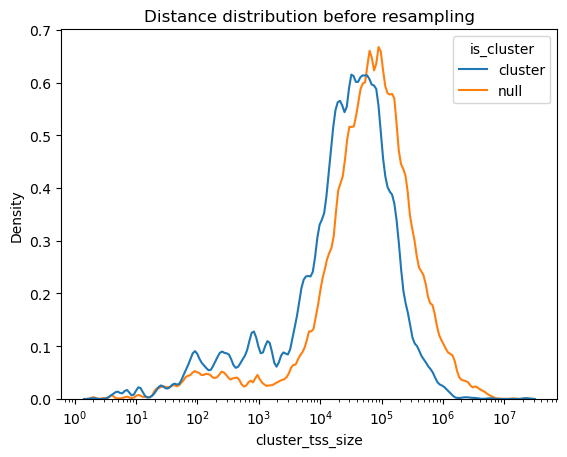

/home/klawren/oak/pcqtls/workflow/scripts/annotate_null_clusters.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['normed_log_size'] = np.log10(cluster_df['cluster_tss_size'])/np.log10(join_df['cluster_tss_size'].max())
/home/klawren/oak/pcqtls/workflow/scripts/annotate_null_clusters.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null_df['normed_log_size'] = np.log10(null_df['cluster_tss_size'])/np.log10(join_df['cluster_tss_size'].max())


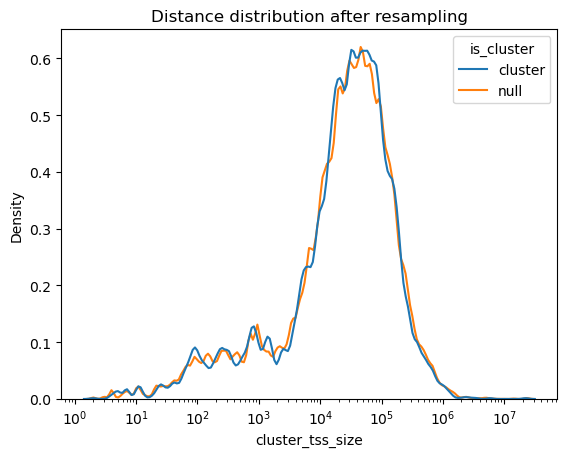

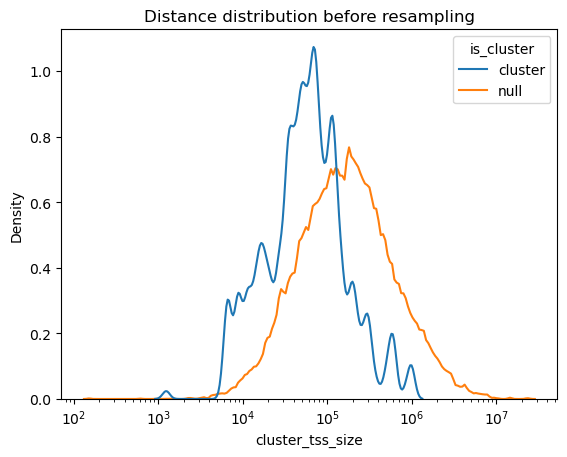

/home/klawren/oak/pcqtls/workflow/scripts/annotate_null_clusters.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['normed_log_size'] = np.log10(cluster_df['cluster_tss_size'])/np.log10(join_df['cluster_tss_size'].max())
/home/klawren/oak/pcqtls/workflow/scripts/annotate_null_clusters.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null_df['normed_log_size'] = np.log10(null_df['cluster_tss_size'])/np.log10(join_df['cluster_tss_size'].max())


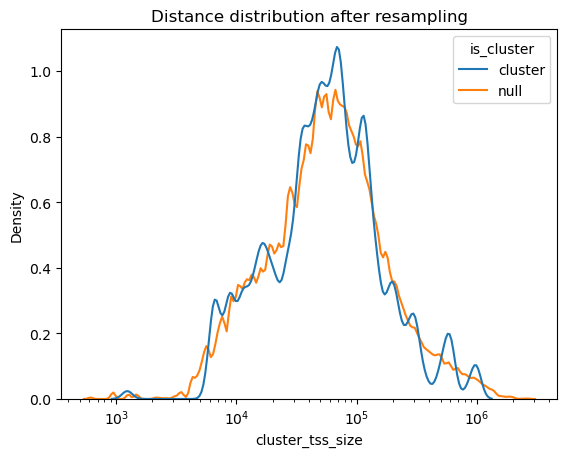

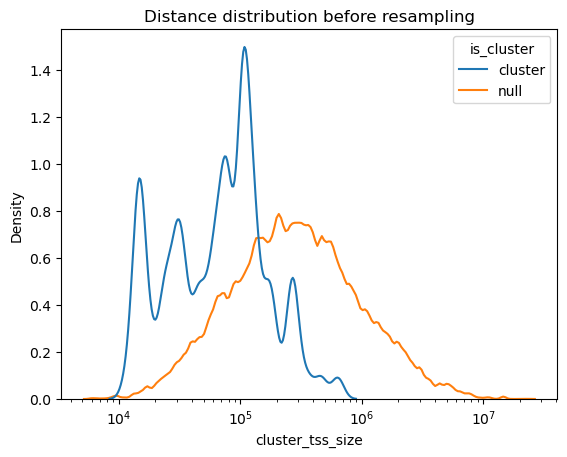

/home/klawren/oak/pcqtls/workflow/scripts/annotate_null_clusters.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['normed_log_size'] = np.log10(cluster_df['cluster_tss_size'])/np.log10(join_df['cluster_tss_size'].max())
/home/klawren/oak/pcqtls/workflow/scripts/annotate_null_clusters.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null_df['normed_log_size'] = np.log10(null_df['cluster_tss_size'])/np.log10(join_df['cluster_tss_size'].max())
/home/klawren/oak/pcqtls/workflow/scripts/annota

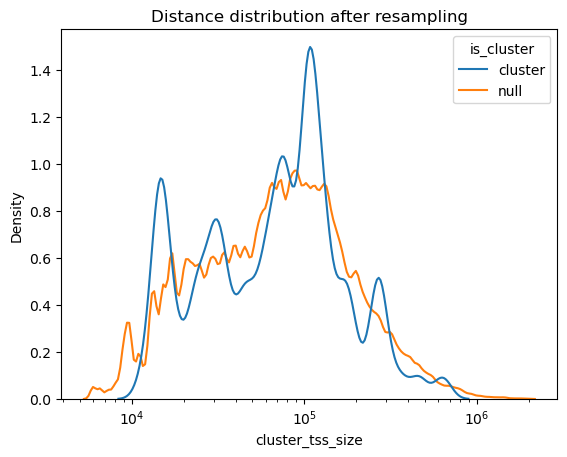

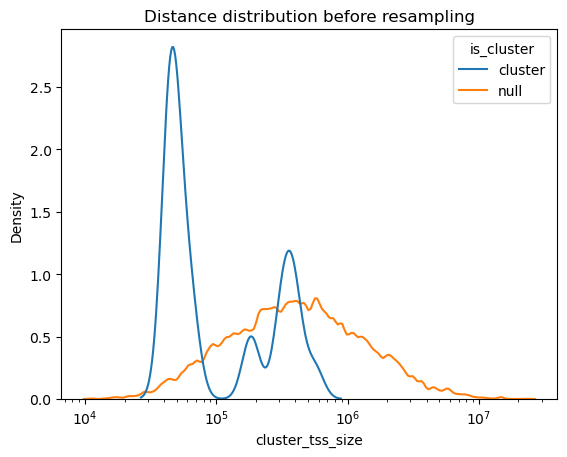

/home/klawren/oak/pcqtls/workflow/scripts/annotate_null_clusters.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['normed_log_size'] = np.log10(cluster_df['cluster_tss_size'])/np.log10(join_df['cluster_tss_size'].max())
/home/klawren/oak/pcqtls/workflow/scripts/annotate_null_clusters.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null_df['normed_log_size'] = np.log10(null_df['cluster_tss_size'])/np.log10(join_df['cluster_tss_size'].max())
/home/klawren/oak/pcqtls/workflow/scripts/annota

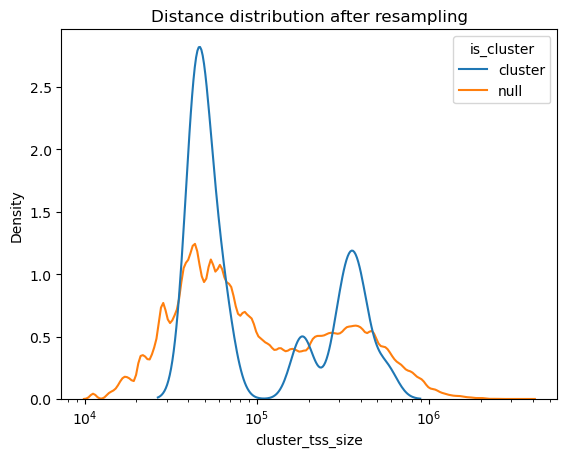

In [ ]:
# make a distance matched null
multitissue_abc_resamp_largerclusters_nulls = []
for num_genes in combined_multigene_nulls['N_genes'].unique():
    cluster_num_genes = combined_clusters[(combined_clusters['N_genes']==num_genes)]
    # don't bother to match if too few clusters of this size, just discard null
    if len(cluster_num_genes) > 2:
        null_num_genes = combined_multigene_nulls[(combined_multigene_nulls['N_genes']==num_genes)]
        multitissue_abc_resamp_largerclusters_nulls.append(get_resamp_null_cluster(null_num_genes, cluster_num_genes, number_null=5000*len(enhancer_tissue_ids), plot=False))

multitissue_abc_resamp_largerclusters_df = pd.concat([combined_clusters, pd.concat(multitissue_abc_resamp_largerclusters_nulls)], keys=['cluster', 'null'], names=['type', 'idx']).reset_index()
multitissue_abc_resamp_largerclusters_df['is_cluster'] = multitissue_abc_resamp_largerclusters_df['type']=='cluster'

In [ ]:
# match number of pos cutoff to number in negative
neg_cutoff = -.01
num_neg = len(combined_clusters[combined_clusters['Mean_cor'] < neg_cutoff])
pos_cutoff = combined_clusters['Mean_cor'].sort_values(ascending=False).iloc[num_neg]

noresamp_cols = ['has_bidirectional_promoter']
noresamp_odds_positive = get_odds_df(multitissue_abc_largerclusters_df[((multitissue_abc_largerclusters_df['type']=='cluster')&(multitissue_abc_largerclusters_df['Mean_pos_cor']>pos_cutoff)) | (multitissue_abc_largerclusters_df['type']=='null')], column_list = noresamp_cols, correct_on=True, correct_on_column='N_genes', label_col='is_cluster')
noresamp_odds_all = get_odds_df(multitissue_abc_largerclusters_df, column_list = noresamp_cols, correct_on=True, correct_on_column='N_genes', label_col='is_cluster')
noresamp_odds_negative = get_odds_df(multitissue_abc_largerclusters_df[((multitissue_abc_largerclusters_df['type']=='cluster')&(multitissue_abc_largerclusters_df['Mean_neg_cor']<neg_cutoff)) | (multitissue_abc_largerclusters_df['type']=='null')], column_list = noresamp_cols, correct_on=True, correct_on_column='N_genes', label_col='is_cluster')

resamp_column_list = ['has_tads_tss', 
                      'has_paralog', 
                      'has_shared_go_any',
                      'has_ctcf_peak',
                      'has_shared_enhancer']

bool_filter_list = ['has_shared_enhancer']

resamp_odds_positive = get_odds_df(multitissue_abc_resamp_largerclusters_df[((multitissue_abc_resamp_largerclusters_df['type']=='cluster')&(multitissue_abc_resamp_largerclusters_df['Mean_pos_cor']>pos_cutoff)) | (multitissue_abc_resamp_largerclusters_df['type']=='null')], column_list=resamp_column_list, filter_list=bool_filter_list, correct_on=True, correct_on_column='N_genes', label_col='is_cluster') 
resamp_odds_all = get_odds_df(multitissue_abc_resamp_largerclusters_df, column_list=resamp_column_list, filter_list=bool_filter_list, correct_on=True, correct_on_column='N_genes', label_col='is_cluster')
resamp_odds_negative = get_odds_df(multitissue_abc_resamp_largerclusters_df[((multitissue_abc_resamp_largerclusters_df['type']=='cluster')&(multitissue_abc_resamp_largerclusters_df['Mean_neg_cor']<neg_cutoff)) | (multitissue_abc_resamp_largerclusters_df['type']=='null')], column_list=resamp_column_list, filter_list=bool_filter_list, correct_on=True, correct_on_column='N_genes', label_col='is_cluster')


has_bidirectional_promoter
Optimization terminated successfully.
         Current function value: 0.011695
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               132376
Model:                          Logit   Df Residuals:                   132373
Method:                           MLE   Df Model:                            2
Date:                Wed, 18 Dec 2024   Pseudo R-squ.:                  0.1114
Time:                        19:03:35   Log-Likelihood:                -1548.2
converged:                       True   LL-Null:                       -1742.2
Covariance Type:            nonrobust   LLR p-value:                 5.284e-85
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.6579      0.301

In [121]:
num_neg

234

[Text(0, 0.2, 'crosses TAD boundry'),
 Text(0, 1.2, 'CTCF peak between TSSs'),
 Text(0, 2.2, 'shared ABC enhancer'),
 Text(0, 3.2, 'bidirectional promoter'),
 Text(0, 4.2, 'shared GO term'),
 Text(0, 5.2, 'paralogs')]

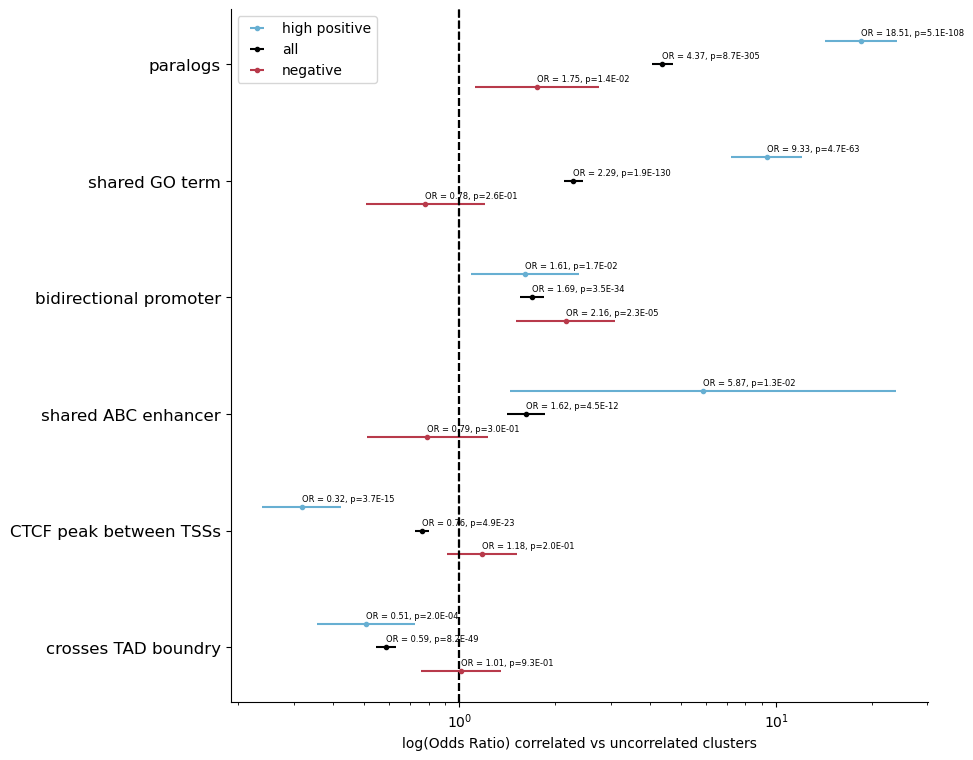

In [120]:
# combined, resampled and nonresampled columns
col_order = ['has_tads_tss', 'has_ctcf_peak', 'has_shared_enhancer', 'has_bidirectional_promoter', 'has_shared_go_any', 'has_paralog']
odds_negative = pd.concat([noresamp_odds_negative, resamp_odds_negative]).loc[col_order] 
odds_all = pd.concat([noresamp_odds_all, resamp_odds_all]).loc[col_order] 
odds_positive = pd.concat([noresamp_odds_positive, resamp_odds_positive]).loc[col_order] 

# make the plot
ax = make_log_odds_plot_multiple([odds_negative, odds_all, odds_positive], 
                             labels=['negative', 'all', 'high positive',], 
                             colors = sns.color_palette('blend:#B83A4B,k,#67AFD2', n_colors=3))

ax.set_xlabel('log(Odds Ratio) correlated vs uncorrelated clusters')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks(fontsize=3) 

ax.set_yticklabels(np.array(['paralogs',  'shared GO term',  'bidirectional promoter', 'shared ABC enhancer',  'CTCF peak between TSSs',  'crosses TAD boundry'])[::-1], fontsize=12)


### supp figure: cross mappable clusters

In [ ]:
clusters_annotated = load_across_tissues(config, load_clusters_annotated)
sns.histplot(clusters_annotated, x='num_cross_map', hue='has_cross_map', bins=np.arange(0, clusters_annotated['num_cross_map'].max()))

supp: pos vs neg

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


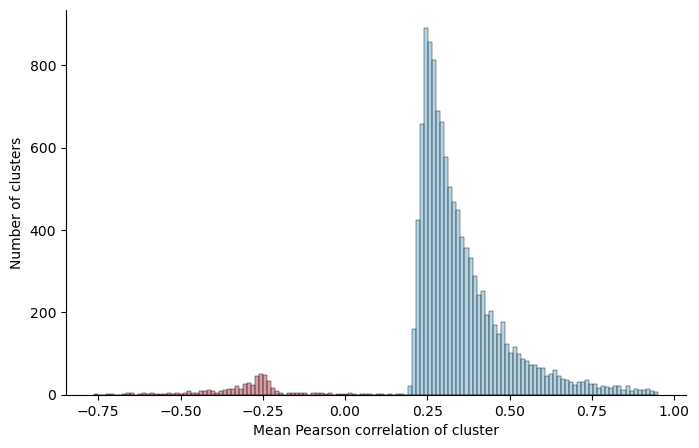

In [123]:
fig, ax = plt.subplots(figsize=(8,5))

clusters['has_pos_corr'] = clusters['Mean_cor'] > 0
sns.histplot(clusters, x='Mean_cor', hue='has_pos_corr', palette=({True:tissue_pal[-1], False:tissue_pal[0]}), ax=ax)
ax.set_ylabel('Number of clusters')
ax.set_xlabel('Mean Pearson correlation of cluster')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend().remove()
